### based on
- http://localhost:8187/notebooks/tsainbur/Projects/github_repos/cdcp_chronic/notebooks/neural-analysis/spiketrain_analyses/analyses/1.0-determine-categorical-units.ipynb
- http://localhost:8187/notebooks/tsainbur/Projects/github_repos/cdcp_chronic/notebooks/neural-analysis/spiketrain_analyses/analyses/analyze-spike-shape.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
#os.nice(1)

In [3]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed
from datetime import datetime
from joblib import Parallel, delayed
from functools import reduce
from sklearn.decomposition import PCA
from functools import reduce


/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [4]:
import seaborn as sns
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic
import scipy.stats
from cdcp.spiketrain_analysis.neurometric import (
    get_interp_points_dists_from_similarity_matrix,
)

In [5]:
from cdcp.visualization.colors import nuclei_dict
from scipy import interpolate

In [6]:
%matplotlib inline

In [7]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [8]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    ('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    ('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    ('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    ('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]
birds_df = pd.DataFrame(birds, columns = ['bird', 'timestamp', 'sorter']).set_index('bird')

In [9]:
identifiers = ['spike_shape', 'spike_count', 'unit_location']# , 

In [10]:
n_interp_bins = 16

In [11]:
all_unit_statistics_df= []
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    
    unit_statistics_df_list = []
    for identifier in identifiers:
        unit_statistics_df = pd.read_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / identifier
        / "{}.pickle".format(bird)
    )
        unit_statistics_df_list.append(unit_statistics_df)
        
    print(bird, 'nrows per', [len(i) for i in unit_statistics_df_list])
    
    # combine dfs
    unit_statistics_df = reduce(lambda x, y: pd.merge(x, y, on = 'unit', how='outer'), unit_statistics_df_list)
    unit_statistics_df['bird'] = bird
    
    all_unit_statistics_df.append(unit_statistics_df)
unit_statistics_df = pd.concat(all_unit_statistics_df)

birds:   0%|          | 0/14 [00:00<?, ?it/s]

B1597 nrows per [6750, 6750, 8711]
B1188 nrows per [603, 510, 821]
B1595 nrows per [242, 242, 325]
B1276 nrows per [46, 46, 57]
B1426 nrows per [107, 93, 180]
B1432 nrows per [2198, 2157, 2364]
B1170 nrows per [1281, 1281, 1693]
B1244 nrows per [141, 141, 150]
B1593 nrows per [7966, 7714, 13260]
B1248 nrows per [8698, 8698, 13184]
B1279 nrows per [827, 827, 1126]
B1500 nrows per [307, 307, 377]
B1239 nrows per [206, 206, 212]
B1459 nrows per [447, 447, 460]


In [12]:
unit_statistics_df = unit_statistics_df[unit_statistics_df.n_trials > 1000]

In [13]:
len(unit_statistics_df)

29230

In [14]:
unit_statistics_df[:3]

,half_width,full_width,best_channel_template,highest_amplitude_channel_template,spike_rate,spike_amplitude,presence_ratio,isi_violation_rate,unit,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,hemisphere,labeled_region,estimated_nuclei,distance_to_estimated_nuclei,ML,AP,DV,bird
0,21.0,38.0,"[-15.0, -11.5, 12.5, 28.5, 44.0, 60.5, 98.5, 1...","[-15.0, -11.5, 12.5, 28.5, 44.0, 60.5, 98.5, 1...",0.157927,-552.5,1.0,0.05409,8481,5839,207,13,65,23,5598,241,523,NaN,NaN,NCL,479.334,2757.25,2420.0,-782.499502,B1597
1,10.0,20.0,"[-14.0, -5.0, 15.0, 19.0, 33.0, 38.0, 30.0, 19...","[-14.0, -5.0, 15.0, 19.0, 33.0, 38.0, 30.0, 19...",8.381143,-64.0,1.0,0.012505,203,6216,6,0,0,0,6208,8,46346,NaN,NaN,NCL,503.047,2717.25,2420.0,-722.499502,B1597
2,3.5,13.0,"[24.0, 23.5, 23.5, 23.0, 26.0, 24.25, 25.75, 2...","[24.0, 23.5, 23.5, 23.0, 26.0, 24.25, 25.75, 2...",18.982587,-365.75,1.0,0.613179,982,6206,1,0,0,0,6205,1,105270,NaN,NaN,NCL,503.047,2717.25,2420.0,-722.499502,B1597


### Get centered template

In [15]:
60 / 30000

0.002

In [16]:
1000 / 60

16.666666666666668

In [17]:
def center_i(i, pad_width = 60):
    if type(i) != np.ndarray:
        return np.nan
    argmax = np.argmax(np.abs(i))
    pad = np.min([len(i) - argmax, argmax])
    centered = i[argmax - pad:argmax+pad]
    centered = np.pad(centered, pad_width)
    if len(centered) > pad_width:
        zp = int((len(centered) - pad_width) / 2)
        centered = centered[zp:-zp]
    # resample    
    y = centered
    x = np.arange(len(y))
    x2 = np.linspace(x[0], x[-1], 1000)
    f = interpolate.interp1d(x, y,kind='linear')
    y2 = f(x2)
    return y2

In [18]:
good_template_mask = np.array(
    [
        True if type(i) == np.ndarray else False
        for i in unit_statistics_df.best_channel_template.values
    ]
)
np.mean(good_template_mask)

0.9862812179267876

In [19]:
unit_statistics_df = unit_statistics_df[good_template_mask]

In [20]:
best_chan_templates = np.array(
    [
        center_i(i, pad_width=60)
        for i in unit_statistics_df.highest_amplitude_channel_template.values
    ]
)
best_chan_range = (np.max(best_chan_templates, axis=1) - np.min(best_chan_templates, axis=1))
best_chan_templates_norm = (
    best_chan_templates.T / best_chan_range
).T

/home/AD/tsainbur/anaconda3/envs/cdcp_paper/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


### Get amplitude and spike width

In [21]:
len(best_chan_templates)

28829

In [22]:
template_amplitude = np.max(np.abs(best_chan_templates), axis=1)

In [23]:
def get_half_full_width(i, w = 100):
    i = np.abs(i)  - 0.5
    pre = np.where(np.sign(i[:int(w/2)-1]) != np.sign(i[1:int(w/2)]))[0]
    if len(pre) > 0:
        pre = int(w/2)-pre[-1]
    else:
        pre = np.nan
    post = np.where(np.sign(i[int(w/2):-1]) != np.sign(i[int(w/2)+1:]))[0]
    if len(post) > 0:
        post = post[0]
    else:
        post = np.nan
    half = post
    full = post+pre
    return half, full

In [24]:
full_width = np.array([get_half_full_width(i, w=len(best_chan_templates_norm[0]))[1] for i in best_chan_templates_norm])
half_width = np.array([get_half_full_width(i, w=len(best_chan_templates_norm[0]))[0] for i in best_chan_templates_norm])

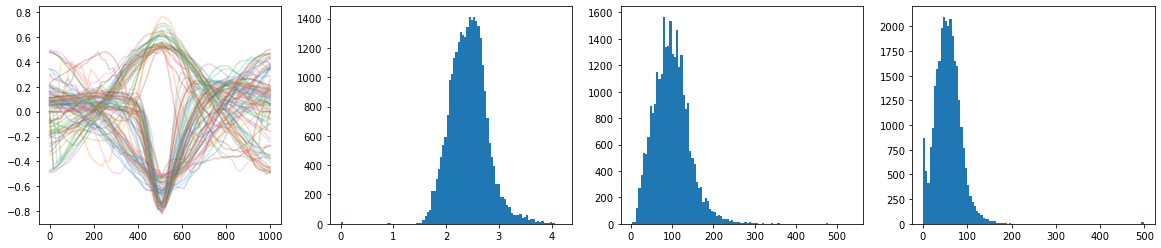

In [25]:
fig, axs = plt.subplots(ncols=4, figsize=(20,4))
ax = axs[0]
ax.plot(
    best_chan_templates_norm[:100].T, alpha = 0.25
);
ax = axs[1]
ax.hist(np.log10(1+template_amplitude.astype(float)), bins = 100);
ax = axs[2]
ax.hist(full_width.astype(float), bins = 100);
ax = axs[3]
ax.hist(half_width.astype(float), bins = 100);

# remove bad units based upon template

In [26]:
mask_starting_amplitude = (np.max(best_chan_templates_norm[:, :100], axis=1) > 0.3)
mask_center_sign = (best_chan_templates[:, int(best_chan_templates.shape[1] / 2)] > 0)
mask_spike_width = (half_width > 200)
mask_max_amplitude = (template_amplitude > 2000)
mask_ending_amplitude = (best_chan_templates_norm[:, -1] > 0.35)
bad_templates = (
    mask_starting_amplitude
    #| (best_chan_templates_norm[:, -1] < -0.5)
    | mask_ending_amplitude
    | mask_spike_width
    | mask_max_amplitude
    | mask_center_sign
)

In [27]:
np.sum(bad_templates), len(bad_templates), np.sum(bad_templates)/len(bad_templates)

(14423, 28829, 0.5002948419993757)

In [28]:
ax.plot(
    best_chan_templates_norm[
        (mask_center_sign == False)
        & (mask_max_amplitude == False)
        & (mask_max_amplitude == False)
        & (mask_starting_amplitude == False)
        &  (best_chan_templates_norm[:, -1] > 0.1)
        #& (mask_ending_amplitude == False)
    ][:100].T, alpha = 0.25
);

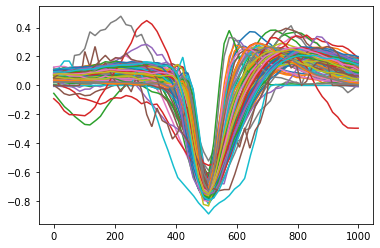

In [29]:
plt.plot(best_chan_templates_norm[(bad_templates == False)&(best_chan_templates_norm[:, -1] <0.2)][:100].T);

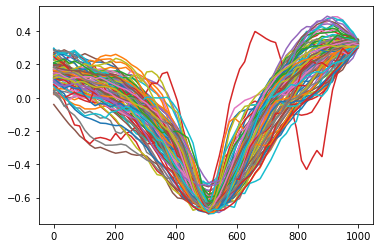

In [30]:
plt.plot(best_chan_templates_norm[(bad_templates == False)&(best_chan_templates_norm[:, -1] > 0.3)][:100].T);

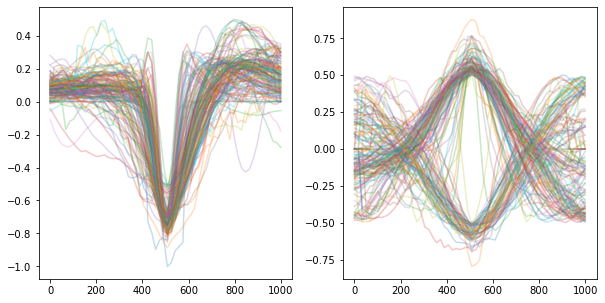

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].plot(best_chan_templates_norm[(bad_templates == False)][::100].T, alpha = 0.25);
axs[1].plot(best_chan_templates_norm[(bad_templates == True)][::100].T, alpha = 0.25);

In [32]:
# remove bad templates
good_template_mask[np.where(good_template_mask==True)[0][bad_templates]]  = False
np.mean(good_template_mask)

0.4928498118371536

In [49]:
np.sum(good_template_mask), np.mean(good_template_mask), len(good_template_mask)

(14406, 0.4928498118371536, 29230)

# Create template dataframe

In [34]:
amplitude = np.array([row.spike_amplitude for idx, row in unit_statistics_df.iterrows()])

In [35]:
bird = np.array([row.bird for idx, row in unit_statistics_df.iterrows()])
unit = np.array([row.unit for idx, row in unit_statistics_df.iterrows()])
nuclei = np.array([row.estimated_nuclei for idx, row in unit_statistics_df.iterrows()])
AP = np.array([row.AP for idx, row in unit_statistics_df.iterrows()])
ML = np.array([row.ML for idx, row in unit_statistics_df.iterrows()])
DV = np.array([row.DV for idx, row in unit_statistics_df.iterrows()])
sr = np.array([row.spike_rate for idx, row in unit_statistics_df.iterrows()])
best_chan_templates = np.stack([i for i in best_chan_templates])

In [36]:
len(unit)

28829

In [37]:
len(best_chan_templates)

28829

In [38]:
template_info = pd.DataFrame({
    "best_chan_templates":list(best_chan_templates),
    "best_chan_templates_norm":list(best_chan_templates_norm),
    "nuclei":nuclei,
    "AP":AP,
    "ML":ML,
    "DV":DV,
    "amplitude":amplitude,
    "template_amplitude": template_amplitude,
    "sr":sr,
    "fw":full_width,
    "hw":half_width,
    "bird":bird,
    "unit":unit,
})
template_info = template_info[bad_templates == False]
template_info[:3]

,best_chan_templates,best_chan_templates_norm,nuclei,AP,ML,DV,amplitude,template_amplitude,sr,fw,hw,bird,unit
2,"[22.0, 22.05905905905906, 22.11811811811812, 2...","[0.04386099708032402, 0.04397874204473111, 0.0...",NCL,2420.0,2717.25,-722.499502,-365.75,365.649900,18.982587,64.0,35,B1597,982
7,"[39.75, 39.528528528528525, 39.30705705705706,...","[0.05518305414255926, 0.05487559572240221, 0.0...",Field_L,2420.0,2544.25,-822.499502,-559.75,559.589339,10.697164,72.0,38,B1597,11599
8,"[27.0, 27.11811811811812, 27.236236236236238, ...","[0.03453874708847825, 0.03468984530359857, 0.0...",NCL,2420.0,2924.25,-762.499502,-587.00,586.815816,0.633780,60.0,36,B1597,6067


### plot width and amplitude 

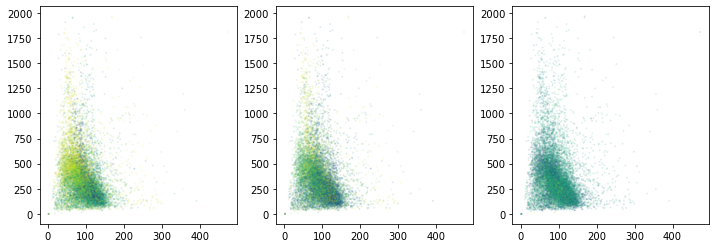

In [39]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for axi, axis in enumerate(["AP", "ML", "DV"]):
    ax = axs[axi]
    ax.scatter(
        template_info.fw.values,
        template_info.template_amplitude.values,
        s=1,
        c=template_info[axis].values,
        alpha = 0.1,
    )

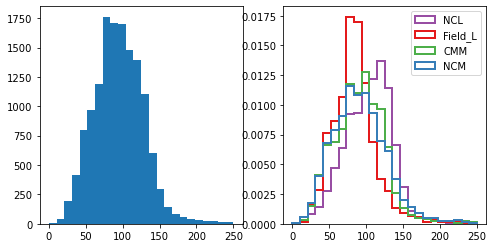

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=(8,4))
bins = np.linspace(0, 250, 25)
axs[0].hist(template_info.fw.values, bins = bins)

for region in template_info.nuclei.unique():
    axs[1].hist(
        template_info[
            template_info.nuclei == region
        ].fw.values,
        bins=bins,
        lw=2,
        color = nuclei_dict[region],
        histtype=u"step",
        density=True,
        label=region
    )
axs[1].legend()

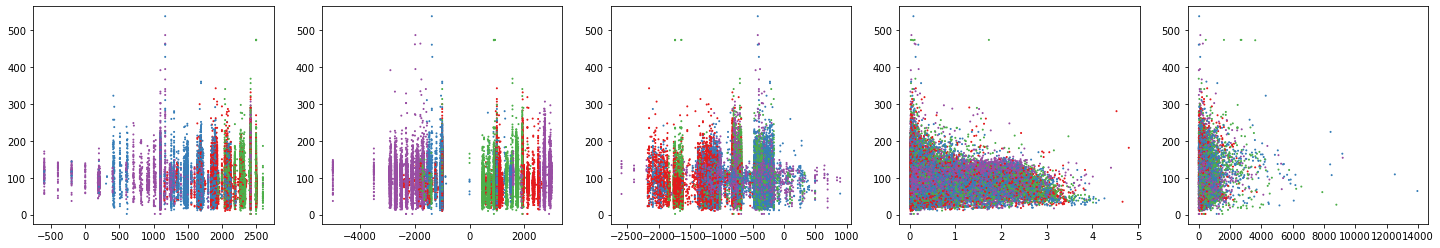

In [41]:
c = [nuclei_dict[i] for i in nuclei]

fw = full_width

fig, axs = plt.subplots(ncols=5, figsize=(25,4))
axs[0].scatter(AP, fw, s = 1, c = c)
axs[1].scatter(ML, fw, s = 1, c = c)
axs[2].scatter(DV, fw, s = 1, c = c)
axs[3].scatter(np.log(1+sr), fw, s = 1, c = c)
axs[4].scatter(np.abs(amplitude), fw, s = 1, c = c)

In [42]:
def zero_one_norm(x):
    return (x-np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))

In [43]:
colors = plt.cm.turbo(zero_one_norm(template_info.fw))

(array([ 520., 2515., 4650., 4066., 2137.,  340.,  115.,   34.,   20.,
           9.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

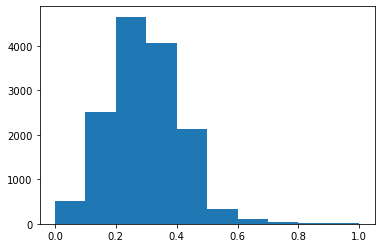

In [44]:
plt.hist(zero_one_norm(template_info.hw))

  0%|          | 0/1441 [00:00<?, ?it/s]

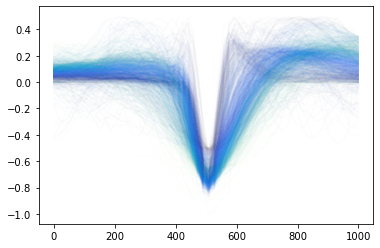

In [45]:
for i, ci in zip(template_info.best_chan_templates_norm[::10], tqdm(colors[::10])):
    plt.plot(i, c = ci, alpha = 0.01)

In [46]:
ensure_dir(DATA_DIR / 'spike_shape')

In [47]:
template_info.to_pickle(DATA_DIR / 'spike_shape' / 'template-info-11-14-21.pickle')

In [48]:
#### 